# mESC analysis using Cyclum with Prior Knowledge (More Weights)

We utilize prior knowledge by giving marker genes more weights.

We still use the mESC dataset. For simplicity we have converted the dataset into TPM.
The original count data is available at ArrayExpress: [E-MTAB-2805](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2805/). Tools to transform data are also provided and explained in the following sections.

In [ ]:
# Add ../../ to path
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

## Import necessary packages

In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import pandas as pd
import numpy as np
import sklearn as skl

In [21]:
import cyclum.tuning
import cyclum.models
from cyclum import writer


## Read data
Here we have label, so we load both. However, the label is not used until evaluation.

In [22]:
input_file_mask = '/home/shaoheng/Documents/data/mESC/mesc-tpm'

def preprocess(input_file_mask):
    """
    Read in data and perform log transform (log2(x+1)), centering (mean = 1) and scaling (sd = 1).
    """
    tpm = writer.read_df_from_binary(input_file_mask).T
    sttpm = pd.DataFrame(data=skl.preprocessing.scale(np.log2(tpm.values + 1)), index=tpm.index, columns=tpm.columns)
    
    label = pd.read_csv(input_file_mask + '-label.txt', sep="\t", index_col=0).T
    return sttpm, label

sttpm, label = preprocess(input_file_mask)

In [23]:
marker_df = pd.read_table('../../data/MGI-cell-cycle-0007049.txt', index_col=False)
marker_df.head()

gene_list = list(set(marker_df['Symbol'].unique().tolist()).intersection(sttpm.columns))
gene_list

sttpm.loc[:, gene_list].head()

,Rock1,Gas2l1,Pik3r4,Tubb6,Il12a,Ttk,Pmf1,Smc3,Irf1,Ahctf1,...,Cirbp,Gm4297,Rptor,Mos,Plcb1,Pbk,Nek2,Trim36,Evi5,Atp2b4
G1_cell1_count,0.795471,0.929152,-0.917957,0.487101,-0.086259,0.119715,0.776429,1.156811,-1.329301,-1.090155,...,-1.026106,-0.059028,1.483870,-0.206394,-0.059028,0.973693,-0.642498,-0.258689,-0.781634,-0.890501
G1_cell2_count,0.731163,-0.826100,-1.132643,0.874655,4.323736,-0.934896,0.541499,0.091779,-0.005898,0.659847,...,-0.846690,-0.059028,-0.666970,-0.206394,-0.059028,-2.066644,-0.642498,0.056135,1.833872,1.873185
G1_cell3_count,0.478532,1.431123,-0.050220,-0.146180,-0.086259,-0.120335,-0.263282,0.412568,0.850264,-0.001157,...,1.420302,-0.059028,0.046477,-0.206394,-0.059028,0.250297,-0.316149,0.797269,-0.184569,-0.323287
G1_cell4_count,0.899609,2.769476,-1.132643,-1.176229,-0.086259,-1.500864,-2.676408,0.680631,-0.746868,-1.745781,...,-0.529429,-0.059028,-0.964622,-0.206394,-0.059028,-1.602318,-0.642498,-0.258689,2.746986,1.313916
G1_cell5_count,1.842080,-0.826100,-0.607774,0.305226,-0.086259,-1.442478,0.646417,-0.293779,-1.329301,-1.758807,...,-2.362927,-0.059028,-0.029987,-0.206394,-0.059028,0.700365,-0.642498,-0.258689,0.288372,-0.572226


In [24]:
sttpm.loc[:, gene_list] *= 2

sttpm.loc[:, gene_list].head()

,Rock1,Gas2l1,Pik3r4,Tubb6,Il12a,Ttk,Pmf1,Smc3,Irf1,Ahctf1,...,Cirbp,Gm4297,Rptor,Mos,Plcb1,Pbk,Nek2,Trim36,Evi5,Atp2b4
G1_cell1_count,1.590942,1.858303,-1.835913,0.974202,-0.172518,0.239430,1.552858,2.313621,-2.658602,-2.180309,...,-2.052211,-0.118056,2.967739,-0.412789,-0.118056,1.947386,-1.284996,-0.517378,-1.563267,-1.781002
G1_cell2_count,1.462325,-1.652201,-2.265286,1.749309,8.647473,-1.869792,1.082998,0.183558,-0.011795,1.319693,...,-1.693380,-0.118056,-1.333939,-0.412789,-0.118056,-4.133288,-1.284996,0.112270,3.667744,3.746371
G1_cell3_count,0.957064,2.862246,-0.100441,-0.292360,-0.172518,-0.240670,-0.526564,0.825135,1.700527,-0.002314,...,2.840603,-0.118056,0.092953,-0.412789,-0.118056,0.500595,-0.632299,1.594539,-0.369139,-0.646574
G1_cell4_count,1.799218,5.538951,-2.265286,-2.352458,-0.172518,-3.001728,-5.352815,1.361263,-1.493737,-3.491562,...,-1.058858,-0.118056,-1.929244,-0.412789,-0.118056,-3.204635,-1.284996,-0.517378,5.493972,2.627832
G1_cell5_count,3.684160,-1.652201,-1.215548,0.610453,-0.172518,-2.884956,1.292834,-0.587559,-2.658602,-3.517613,...,-4.725853,-0.118056,-0.059975,-0.412789,-0.118056,1.400729,-1.284996,-0.517378,0.576744,-1.144452


There is no convention whether cells should be columns or rows. Here we require cells to be rows.

## Set up the model and fit the model

In [25]:
model = cyclum.tuning.CyclumAutoTune(sttpm, max_linear_dims=5, 
                                     epochs=500, rate=2e-4, verbose=100,
                                     encoder_width=[30, 20])

Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch: 100/500, loss:  0.8298, time elapsed:  32.31s, time left:  129.23s
epoch: 200/500, loss:  0.8212, time elapsed:  63.16s, time left:  94.74s
epoch: 300/500, loss:  0.8166, time elapsed:  94.04s, time left:  62.69s
epoch: 400/500, loss:  0.8142, time elapsed:  124.91s, time left:  31.23s
epoch: 500/500, loss:  0.8121, time elapsed:  155.73s, time left:  0.00s
[0.8121262457635667]
[0.7840205605934473, 0.7726384155715207, 0.7642100231413654, 0.7572218128166743, 0.7506621469737493, 0.745134816389744, 0.7397957575604982]
    1 linear dimensions...
epoch: 100/500, loss:  0.7778, time elapsed:  31.65s, time left:  126.60s
epoch: 200/500, loss:  0.7735, time elapsed:  62.96s, time left:  94.44s
epoch: 300/500, loss:  0.7714, time elapsed:  94.28s, time l

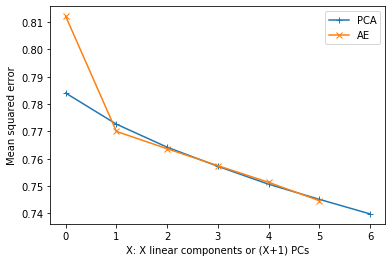

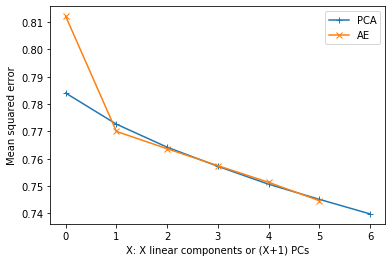

In [26]:
model.show_elbow()

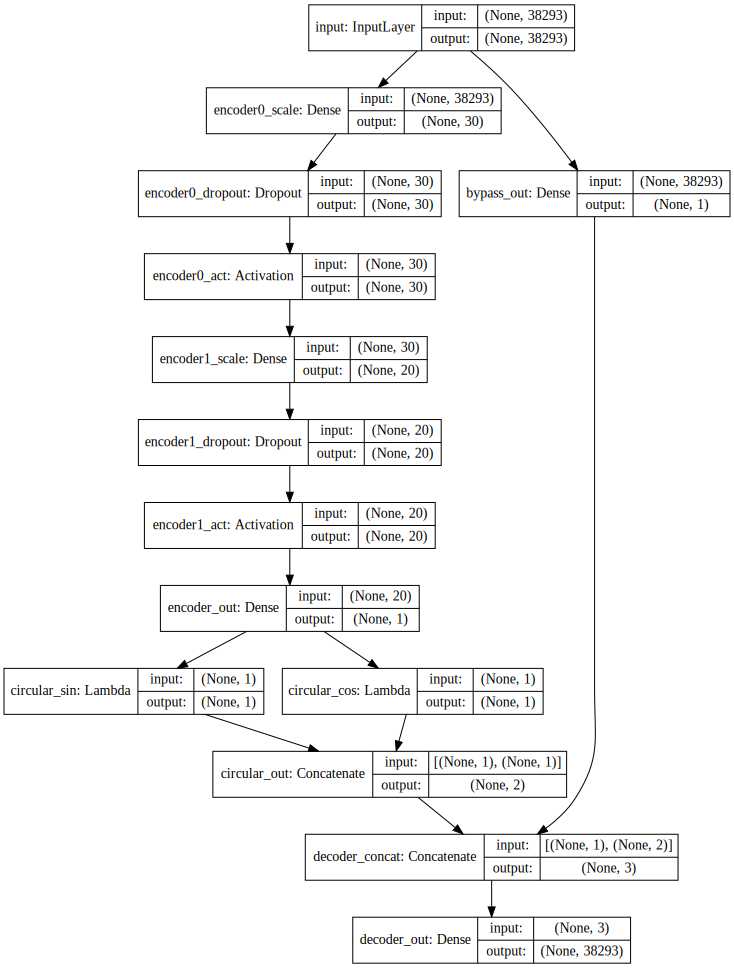

In [27]:
display(model.show_structure())


In [28]:
model.train(sttpm, epochs=1600, verbose=100, rate=2e-4)

epoch: 100/1600, loss:  0.7777, time elapsed:  37.40s, time left:  561.03s
epoch: 200/1600, loss:  0.7730, time elapsed:  74.49s, time left:  521.41s
epoch: 300/1600, loss:  0.7709, time elapsed:  112.24s, time left:  486.38s
epoch: 400/1600, loss:  0.7701, time elapsed:  147.82s, time left:  443.47s
epoch: 500/1600, loss:  0.7697, time elapsed:  183.25s, time left:  403.15s
epoch: 600/1600, loss:  0.7693, time elapsed:  222.34s, time left:  370.56s
epoch: 700/1600, loss:  0.7692, time elapsed:  262.78s, time left:  337.86s
epoch: 800/1600, loss:  0.7694, time elapsed:  300.19s, time left:  300.19s
epoch: 900/1600, loss:  0.7693, time elapsed:  332.87s, time left:  258.90s
epoch: 1000/1600, loss:  0.7690, time elapsed:  365.41s, time left:  219.24s
epoch: 1100/1600, loss:  0.7688, time elapsed:  397.64s, time left:  180.74s
epoch: 1200/1600, loss:  0.7690, time elapsed:  429.72s, time left:  143.24s
epoch: 1300/1600, loss:  0.7687, time elapsed:  461.39s, time left:  106.47s
epoch: 140

In [29]:
pseudotime = model.predict_pseudotime(sttpm)

## Illustrations
We illustrate the results on a circle, to show its circular nature. 
There is virtually no start and end of the circle.
Red, green and blue represents G0/G1, S and G2/M phase respectively.
The inner lines represents single cells. The cells spread across the
The areas outside

In [30]:
import cyclum.illustration

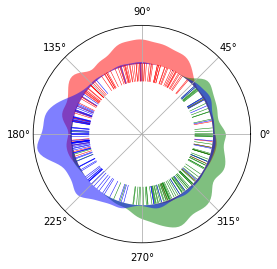

In [31]:
color_map = {'stage': {"g0/g1": "red", "s": "green", "g2/m": "blue"},
                 'subcluster': {"intact": "cyan", "perturbed": "violet"}}
cyclum.illustration.plot_round_distr_color(pseudotime, label['stage'], color_map['stage'])
pass

In [32]:
from cyclum.hdfrw import mat2hdf
mat2hdf(pseudotime, '/home/shaoheng/Documents/data/EMTAB2805/cyclum-marker-weighted-pseudotime.h5')